In [1]:
import os
import sys
import subprocess
import time
import traci

# Nom du dossier où on stocke les fichiers SUMO
SUMO_FOLDER = "sumo_configs"

# Création du dossier s'il n'existe pas déjà
if not os.path.exists(SUMO_FOLDER):
    os.makedirs(SUMO_FOLDER)
    print(f"Dossier '{SUMO_FOLDER}' créé.")
else:
    print(f"Dossier '{SUMO_FOLDER}' existe déjà.")

Dossier 'sumo_configs' créé.


In [2]:
# 1. Définition des Noeuds (Nodes) - Une croix simple
nodes_content = """<nodes>
    <node id="center" x="0.0" y="0.0" type="traffic_light"/>
    <node id="N" x="0.0" y="100.0" />
    <node id="S" x="0.0" y="-100.0" />
    <node id="E" x="100.0" y="0.0" />
    <node id="W" x="-100.0" y="0.0" />
</nodes>
"""

# 2. Définition des Routes (Edges)
edges_content = """<edges>
    <edge id="N2C" from="N" to="center" priority="1" numLanes="2" speed="13.89"/>
    <edge id="C2S" from="center" to="S" priority="1" numLanes="2" speed="13.89"/>
    <edge id="E2C" from="E" to="center" priority="1" numLanes="2" speed="13.89"/>
    <edge id="C2W" from="center" to="W" priority="1" numLanes="2" speed="13.89"/>
</edges>
"""

# 3. Définition du Trafic (Véhicules)
# On génère un trafic standard pour commencer
routes_content = """<routes>
    <vType id="car" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2.5" maxSpeed="16.67" guiShape="passenger"/>
    
    <flow id="flow_NS" type="car" begin="0" end="3600" probability="0.2" from="N2C" to="C2S"/>
    
    <flow id="flow_EW" type="car" begin="0" end="3600" probability="0.15" from="E2C" to="C2W"/>
</routes>
"""

# 4. Fichier de Configuration Principal
config_content = """<configuration>
    <input>
        <net-file value="network.net.xml"/>
        <route-files value="routes.rou.xml"/>
    </input>
    <time>
        <begin value="0"/>
        <end value="2000"/>
    </time>
</configuration>
"""

# Écriture des fichiers dans le dossier sumo_configs
def write_file(filename, content):
    path = os.path.join(SUMO_FOLDER, filename)
    with open(path, "w") as f:
        f.write(content)
    print(f"Fichier créé : {path}")

write_file("nodes.nod.xml", nodes_content)
write_file("edges.edg.xml", edges_content)
write_file("routes.rou.xml", routes_content)
write_file("config.sumocfg", config_content)

Fichier créé : sumo_configs\nodes.nod.xml
Fichier créé : sumo_configs\edges.edg.xml
Fichier créé : sumo_configs\routes.rou.xml
Fichier créé : sumo_configs\config.sumocfg


In [4]:
# Cellule 3 (Correction) : Configuration manuelle du PATH et Compilation
import os
import subprocess
import sys

# 1. On cherche où SUMO est installé
possible_paths = [
    r"C:\Program Files (x86)\Eclipse\Sumo",
    r"C:\Program Files\Eclipse\Sumo",
    r"C:\Sumo"
]

sumo_home = None

# Vérification si SUMO_HOME existe déjà
if "SUMO_HOME" in os.environ:
    sumo_home = os.environ["SUMO_HOME"]
    print(f"SUMO_HOME détecté par le système : {sumo_home}")
else:
    # Sinon on cherche manuellement
    for path in possible_paths:
        if os.path.exists(path):
            sumo_home = path
            os.environ["SUMO_HOME"] = path # On force la variable
            print(f"SUMO trouvé ici : {sumo_home}")
            break

if sumo_home is None:
    print("ERREUR CRITIQUE : Impossible de trouver le dossier d'installation de SUMO.")
    print("Avez-vous installé SUMO dans un dossier personnalisé ?")
else:
    # 2. On ajoute le dossier 'bin' au PATH de Python temporairement
    bin_path = os.path.join(sumo_home, "bin")
    if bin_path not in os.environ["PATH"]:
        os.environ["PATH"] += os.pathsep + bin_path
        print(f"Ajout au PATH réussi : {bin_path}")

    # 3. Maintenant on réessaie la commande netconvert
    netconvert_cmd = [
        "netconvert",
        "--node-files", os.path.join(SUMO_FOLDER, "nodes.nod.xml"),
        "--edge-files", os.path.join(SUMO_FOLDER, "edges.edg.xml"),
        "-o", os.path.join(SUMO_FOLDER, "network.net.xml")
    ]

    print("Tentative de compilation...")
    try:
        # shell=True aide parfois sous Windows pour trouver les exe
        result = subprocess.run(netconvert_cmd, capture_output=True, text=True, check=True, shell=True)
        print("✅ SUCCÈS ! Réseau 'network.net.xml' généré.")
    except subprocess.CalledProcessError as e:
        print("❌ ERREUR lors de la compilation :")
        print(e.stderr)
        print("Stdout:", e.stdout)

SUMO trouvé ici : C:\Program Files (x86)\Eclipse\Sumo
Ajout au PATH réussi : C:\Program Files (x86)\Eclipse\Sumo\bin
Tentative de compilation...
✅ SUCCÈS ! Réseau 'network.net.xml' généré.


In [5]:
# Cellule 4 : Lancement de la Simulation avec Interface Graphique
import traci
import os
import sys
import time

# --- RÉ-APPLICATION DE LA CORRECTION DE CHEMIN (Sécurité) ---
# On s'assure que Python connait toujours le chemin vers SUMO
if "SUMO_HOME" not in os.environ:
    # On remet le chemin qui a fonctionné chez vous
    os.environ["SUMO_HOME"] = r"C:\Program Files (x86)\Eclipse\Sumo"
    print("Chemin SUMO_HOME restauré.")

sumo_bin = os.path.join(os.environ["SUMO_HOME"], "bin")
if sumo_bin not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + sumo_bin
# -----------------------------------------------------------

# Chemin absolu vers le fichier de configuration
config_path = os.path.abspath(os.path.join("sumo_configs", "config.sumocfg"))

# Commande de lancement : on utilise "sumo-gui" pour voir la fenêtre
# On ajoute "--start" pour que ça lance la simulation directement sans attendre que vous cliquiez sur Play
sumo_cmd = ["sumo-gui", "-c", config_path, "--start"]

print(f"Lancement de SUMO GUI...")

try:
    # Démarrage de la connexion TraCI
    traci.start(sumo_cmd)
    print("✅ Fenêtre SUMO ouverte ! Regardez votre barre des tâches si elle est cachée.")
    
    step = 0
    # On simule 500 secondes de trafic
    while step < 500:
        traci.simulationStep() # Avance d'une seconde
        
        # --- C'est ici que l'IA va "regarder" la route plus tard ---
        # Pour l'instant, on laisse juste tourner pour tester
        
        step += 1
        time.sleep(0.05) # Petit délai pour rendre l'animation visible à l'œil nu
        
    traci.close()
    print("Simulation terminée proprement.")

except Exception as e:
    print(f"Une erreur est survenue : {e}")
    try:
        traci.close()
    except:
        pass

Lancement de SUMO GUI...
✅ Fenêtre SUMO ouverte ! Regardez votre barre des tâches si elle est cachée.
Simulation terminée proprement.


In [11]:
# Cellule 5 (Version Debug) : Capture Robuste
import traci
import os
import time
import sys

# 1. Nettoyage préventif des connexions
try:
    traci.close()
    print("Ancienne connexion nettoyée.")
except:
    pass

# 2. Configuration des chemins absolus (CRUCIAL pour la capture)
base_dir = os.path.abspath(".") # Dossier actuel
config_path = os.path.join(base_dir, "sumo_configs", "config.sumocfg")
image_path = os.path.join(base_dir, "traffic_capture.png")

# Commande de lancement
sumo_cmd = ["sumo-gui", "-c", config_path, "--start"]

print("🚀 Lancement de SUMO...")
traci.start(sumo_cmd)

# 3. Récupération dynamique de l'ID de la vue
# On demande à SUMO comment s'appelle la fenêtre ouverte
view_ids = traci.gui.getIDList()
if view_ids:
    active_view = view_ids[0]
    print(f"✅ Fenêtre détectée : '{active_view}'")
    
    # Configuration de la vue
    traci.gui.setZoom(active_view, 600)
    traci.gui.setSchema(active_view, "real world")
else:
    print("⚠️ Aucune vue détectée, la capture risque d'échouer.")
    active_view = "View #0" # Fallback

step = 0
captured = False

print("⏳ Début de la boucle de simulation...")

try:
    while step < 100:
        traci.simulationStep() # Avance d'une seconde
        
        # Affichage de progression pour voir si ça bloque
        if step % 10 == 0:
            print(f"   -> Étape {step}/100...")

        # Capture à l'étape 20 (quand les voitures sont là)
        if step == 20 and not captured:
            print(f"📸 Tentative de capture vers : {image_path}")
            try:
                # On force le chemin absolu pour éviter que l'image ne se perde
                traci.gui.screenshot(active_view, image_path)
                print("✅ Commande capture envoyée !")
                captured = True
            except Exception as e:
                print(f"❌ Erreur capture : {e}")

        step += 1
        time.sleep(0.05) # Petit délai pour voir l'animation

    traci.close()
    print("🏁 Simulation terminée.")
    print(f"Vérifiez si l'image existe ici : {image_path}")

except Exception as e:
    print(f"❌ Erreur critique pendant la boucle : {e}")
    try:
        traci.close()
    except:
        pass

🚀 Lancement de SUMO...
✅ Fenêtre détectée : 'View #0'
⏳ Début de la boucle de simulation...
   -> Étape 0/100...
   -> Étape 10/100...
   -> Étape 20/100...
📸 Tentative de capture vers : c:\Users\DELL\Desktop\Projects\Projet IA & Traitement d'image\traffic_capture.png
✅ Commande capture envoyée !
   -> Étape 30/100...
   -> Étape 40/100...
   -> Étape 50/100...
   -> Étape 60/100...
   -> Étape 70/100...
   -> Étape 80/100...
   -> Étape 90/100...
🏁 Simulation terminée.
Vérifiez si l'image existe ici : c:\Users\DELL\Desktop\Projects\Projet IA & Traitement d'image\traffic_capture.png


✅ Image trouvée : traffic_capture.png


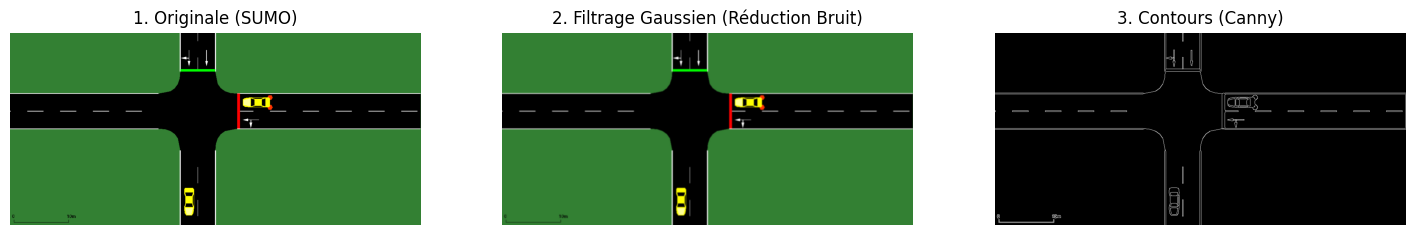

In [1]:
# Cellule 6 : Traitement d'Images Classique (OpenCV)
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Chargement de l'image
image_path = "traffic_capture.png"

if not os.path.exists(image_path):
    print(f"❌ Erreur : Le fichier '{image_path}' est introuvable.")
else:
    print(f"✅ Image trouvée : {image_path}")
    
    # Lecture avec OpenCV
    original_img = cv2.imread(image_path)
    
    # Conversion BGR (format OpenCV) -> RGB (format Affichage)
    img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # --- ETAPE A : Filtrage Gaussien (Réduction de bruit) ---
    # Le cahier des charges demande de réduire le bruit 
    # On utilise un noyau de taille (5,5)
    blurred_img = cv2.GaussianBlur(original_img, (5, 5), 0)
    
    # --- ETAPE B : Détection de Contours (Canny) ---
    # Le cahier des charges demande l'algorithme de Canny 
    # Seuils : 50 (bas) et 150 (haut) pour bien capter les bords des voitures
    edges = cv2.Canny(blurred_img, 50, 150)
    
    # --- ETAPE C : Affichage Comparatif ---
    plt.figure(figsize=(18, 6))

    # 1. Image Originale
    plt.subplot(1, 3, 1)
    plt.title("1. Originale (SUMO)")
    plt.imshow(img_rgb)
    plt.axis('off')

    # 2. Image Floutée
    plt.subplot(1, 3, 2)
    plt.title("2. Filtrage Gaussien (Réduction Bruit)")
    plt.imshow(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # 3. Contours (Canny)
    plt.subplot(1, 3, 3)
    plt.title("3. Contours (Canny)")
    plt.imshow(edges, cmap='gray') # Affichage en niveaux de gris
    plt.axis('off')

    plt.show()

In [2]:
# Cellule 7 : Installation de YOLO (Ultralytics)
import sys
# On installe la librairie officielle de YOLOv8
!{sys.executable} -m pip install ultralytics
print("Installation de YOLO terminée.")

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ------------------ --------------------- 0.5/1.1 MB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 3.2 MB/s  0:00:00
   ---------------------------------------- 0.0/802.4 kB ? eta -:--:--
   -------------------------- ------------- 524.3/802.4 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 802.4/802.4 kB 2.7 MB/s  0:00:00
   ---------------------------------------- 0.0/44.5 MB ? eta -:--:--
   ---------------------------------------- 0.5/44.5 MB 3.0 MB/s eta 0:00:15
    --------------------------------------- 1.0/44.5 MB 2.9 MB/s eta 0:00:16
   - -------------------------------------- 1.6/44.5 MB 2.8 MB/s eta 0:00:16
   - -------------------------------------- 2.1/44.5 MB 2.8 MB/s eta 0:00:15
   -- ------------------------------------- 2.6/44.5 MB 2.8 MB/s eta 0:00:15
   --- --------------

✅ Image de test réelle téléchargée : 'test_reel.jpg'
🧠 Analyse de l'image réelle...

image 1/1 c:\Users\DELL\Desktop\Projects\Projet IA & Traitement d'image\test_reel.jpg: 640x480 4 persons, 1 bus, 1 skateboard, 99.9ms
Speed: 2.7ms preprocess, 99.9ms inference, 25.1ms postprocess per image at shape (1, 3, 640, 480)


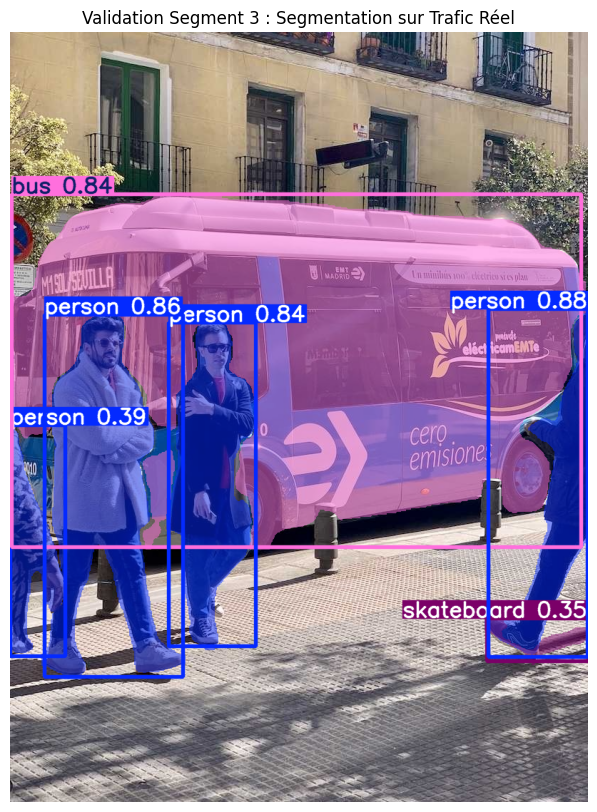


--- 📊 RAPPORT DE DÉTECTION ---
🔹 Détecté : person (Confiance : 0.88)
🔹 Détecté : person (Confiance : 0.86)
🔹 Détecté : person (Confiance : 0.84)
🔹 Détecté : bus (Confiance : 0.84)
🔹 Détecté : person (Confiance : 0.39)

✅ Total objets pertinents : 5


In [4]:
# Cellule 8 (Validation Technique) : Test sur image réelle
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import requests
import numpy as np
from PIL import Image
from io import BytesIO

# 1. Téléchargement d'une image de trafic réel (pour test)
url = "https://ultralytics.com/images/bus.jpg" # Image de test standard YOLO
response = requests.get(url)
image_bytes = BytesIO(response.content)

# Conversion pour OpenCV
pil_image = Image.open(image_bytes)
img_cv2 = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

# Sauvegarde locale pour référence
cv2.imwrite("test_reel.jpg", img_cv2)
print("✅ Image de test réelle téléchargée : 'test_reel.jpg'")

# 2. Chargement de l'IA (Segmentation)
model = YOLO('yolov8n-seg.pt') 

print("🧠 Analyse de l'image réelle...")
# On baisse légèrement le seuil de confiance (conf=0.25 par défaut)
results = model("test_reel.jpg", conf=0.25)

# 3. Affichage des Masques
res_plotted = results[0].plot()
res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 10))
plt.title("Validation Segment 3 : Segmentation sur Trafic Réel")
plt.imshow(res_rgb)
plt.axis('off')
plt.show()

# 4. Rapport
print("\n--- 📊 RAPPORT DE DÉTECTION ---")
boxes = results[0].boxes
compteur = 0
for box in boxes:
    cls_id = int(box.cls[0])
    name = model.names[cls_id]
    conf = float(box.conf[0])
    
    # On filtre pour ne garder que les véhicules et personnes
    if name in ['car', 'bus', 'truck', 'person']:
        print(f"🔹 Détecté : {name} (Confiance : {conf:.2f})")
        compteur += 1

print(f"\n✅ Total objets pertinents : {compteur}")

In [5]:
# Cellule 9 (Version Finale & Robuste) : Extraction des Métriques
import traci
import os
import time
import sys

# --- CONFIGURATION ---
if "SUMO_HOME" not in os.environ:
    os.environ["SUMO_HOME"] = r"C:\Program Files (x86)\Eclipse\Sumo"

sumo_binary = os.path.join(os.environ["SUMO_HOME"], "bin", "sumo-gui.exe")
# Sécurité : si non trouvé dans x86, on cherche dans Program Files standard
if not os.path.exists(sumo_binary):
    sumo_binary = r"C:\Program Files\Eclipse\Sumo\bin\sumo-gui.exe"

# Ajout des outils au path
sys.path.append(os.path.join(os.environ["SUMO_HOME"], "tools"))

# Configuration simulation
config_path = os.path.abspath(os.path.join("sumo_configs", "config.sumocfg"))
sumo_cmd = [sumo_binary, "-c", config_path, "--start"]

print("🚀 Démarrage monitoring...")

try:
    try:
        traci.close() # On ferme toute ancienne connexion
    except:
        pass

    traci.start(sumo_cmd)
    traci.gui.setZoom("View #0", 800)

    # --- CORRECTION ICI : Liste des voies existantes ---
    # On ne met que N2C (Nord->Centre) et E2C (Est->Centre)
    # car S2C et W2C n'existent pas dans votre réseau actuel.
    target_lanes = ["N2C_0", "N2C_1", "E2C_0", "E2C_1"]
    
    # On récupère la liste réelle de toutes les voies pour vérification
    all_existing_lanes = traci.lane.getIDList()

    print("\n--- 📊 TABLEAU DE BORD TRAFIC ---")
    print(f"{'Temps':<6} | {'Voie':<10} | {'Véhicules':<10} | {'File Attente':<15}")
    print("-" * 50)

    step = 0
    while step < 200:
        traci.simulationStep()
        
        if step % 10 == 0:
            something_shown = False
            for lane in target_lanes:
                # SÉCURITÉ : On vérifie si la voie existe vraiment avant de demander
                if lane in all_existing_lanes:
                    # 1. Nombre de véhicules (Densité)
                    count = traci.lane.getLastStepVehicleNumber(lane)
                    
                    # 2. File d'attente (Halting number)
                    # C'est LA donnée clé pour le projet (Segment 4)
                    queue = traci.lane.getLastStepHaltingNumber(lane)
                    
                    if count > 0:
                        print(f"t={step:<4} | {lane:<10} | {count:<10} | {queue:<15}")
                        something_shown = True
            
            if something_shown:
                print("-" * 50)

        step += 1
        time.sleep(0.05)

    traci.close()
    print("🏁 Fin de la collecte des métriques.")

except Exception as e:
    print(f"❌ Erreur : {e}")
    try:
        traci.close()
    except:
        pass

🚀 Démarrage monitoring...

--- 📊 TABLEAU DE BORD TRAFIC ---
Temps  | Voie       | Véhicules  | File Attente   
--------------------------------------------------
t=10   | N2C_0      | 2          | 0              
t=10   | E2C_0      | 1          | 0              
--------------------------------------------------
t=20   | N2C_0      | 3          | 0              
t=20   | E2C_0      | 2          | 0              
--------------------------------------------------
t=30   | N2C_0      | 3          | 0              
t=30   | E2C_0      | 3          | 1              
--------------------------------------------------
t=40   | N2C_0      | 3          | 0              
t=40   | E2C_0      | 4          | 1              
t=40   | E2C_1      | 1          | 1              
--------------------------------------------------
t=50   | N2C_0      | 4          | 1              
t=50   | N2C_1      | 1          | 0              
t=50   | E2C_0      | 3          | 0              
----------------------

In [8]:
# Cellule 10 : Intelligence par Comparaison de Flux (Segment 5)
import traci
import os
import time
import sys

# --- CONFIGURATION (Identique) ---
if "SUMO_HOME" not in os.environ:
    os.environ["SUMO_HOME"] = r"C:\Program Files (x86)\Eclipse\Sumo"
sumo_binary = os.path.join(os.environ["SUMO_HOME"], "bin", "sumo-gui.exe")
if not os.path.exists(sumo_binary):
    sumo_binary = r"C:\Program Files\Eclipse\Sumo\bin\sumo-gui.exe"
sys.path.append(os.path.join(os.environ["SUMO_HOME"], "tools"))

config_path = os.path.abspath(os.path.join("sumo_configs", "config.sumocfg"))
sumo_cmd = [sumo_binary, "-c", config_path, "--start"]

try:
    try:
        traci.close()
    except:
        pass

    traci.start(sumo_cmd)
    TL_ID = "center"
    lane_N = "N2C_0" 
    lane_E = "E2C_0" 
    
    step = 0
    last_switch_time = 0 
    
    print("🧠 SYSTÈME ADAPTATIF : Logique de comparaison activée.")

    while step < 1000:
        traci.simulationStep()
        
        # 1. ACQUISITION DES MÉTRIQUES (Segment 4)
        # On regarde combien de voitures attendent sur chaque axe [cite: 73, 75]
        qN = traci.lane.getLastStepHaltingNumber(lane_N)
        qE = traci.lane.getLastStepHaltingNumber(lane_E)
        
        # Phase actuelle : 0 = Vert Nord, 2 = Vert Est [cite: 86]
        current_phase = traci.trafficlight.getPhase(TL_ID)
        
        # 2. LOGIQUE DÉCISIONNELLE AMÉLIORÉE (Segment 5)
        can_switch = (step - last_switch_time > 5) # Sécurité temps minimum

        if can_switch:
            # CONDITION 1 : Une voie est vide et l'autre a au moins 1 voiture
            if qN > 0 and qE == 0 and current_phase == 2:
                print(f"t={step} | 🟢 Passage Nord : Est est vide.")
                traci.trafficlight.setPhase(TL_ID, 0)
                last_switch_time = step
                
            elif qE > 0 and qN == 0 and current_phase == 0:
                print(f"t={step} | 🟢 Passage Est : Nord est vide.")
                traci.trafficlight.setPhase(TL_ID, 2)
                last_switch_time = step

            # CONDITION 2 : Les deux ont du monde -> On compare les files 
            elif qN > qE + 2 and current_phase == 2: # +2 pour éviter les changements incessants
                print(f"t={step} | 📈 Arbitrage : Nord est plus chargé ({qN} vs {qE}).")
                traci.trafficlight.setPhase(TL_ID, 0)
                last_switch_time = step
                
            elif qE > qN + 2 and current_phase == 0:
                print(f"t={step} | 📈 Arbitrage : Est est plus chargé ({qE} vs {qN}).")
                traci.trafficlight.setPhase(TL_ID, 2)
                last_switch_time = step

        # Monitoring
        sys.stdout.write(f"\r Pas {step} | File Nord: {qN} | File Est: {qE} | Phase: {current_phase}   ")
        sys.stdout.flush()

        step += 1
        time.sleep(0.01)

    traci.close()
    print("\n🏁 Simulation terminée.")

except Exception as e:
    print(f"\n❌ Erreur : {e}")
    try: traci.close()
    except: pass

🧠 SYSTÈME ADAPTATIF : Logique de comparaison activée.
 Pas 16 | File Nord: 1 | File Est: 0 | Phase: 0   t=17 | 🟢 Passage Est : Nord est vide.
 Pas 22 | File Nord: 1 | File Est: 1 | Phase: 2   t=23 | 🟢 Passage Nord : Est est vide.
 Pas 36 | File Nord: 1 | File Est: 1 | Phase: 0   t=37 | 🟢 Passage Est : Nord est vide.
 Pas 42 | File Nord: 1 | File Est: 1 | Phase: 2   t=43 | 🟢 Passage Nord : Est est vide.
 Pas 50 | File Nord: 0 | File Est: 0 | Phase: 0   t=51 | 🟢 Passage Est : Nord est vide.
 Pas 56 | File Nord: 1 | File Est: 0 | Phase: 2   t=57 | 🟢 Passage Nord : Est est vide.
 Pas 63 | File Nord: 1 | File Est: 1 | Phase: 0   t=64 | 🟢 Passage Est : Nord est vide.
 Pas 69 | File Nord: 0 | File Est: 1 | Phase: 2   t=70 | 🟢 Passage Nord : Est est vide.
 Pas 75 | File Nord: 0 | File Est: 1 | Phase: 0   t=76 | 🟢 Passage Est : Nord est vide.
 Pas 82 | File Nord: 0 | File Est: 0 | Phase: 2   t=83 | 🟢 Passage Nord : Est est vide.
 Pas 89 | File Nord: 1 | File Est: 1 | Phase: 0   t=90 | 🟢 Passage

In [15]:
# Cellule 11 : Mise à jour avec flux d'urgences multiple
import os

routes_emergency_xml = """<routes>
    <vType id="car" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2.5" maxSpeed="7.0" guiShape="passenger"/>
    
    <vType id="emergency" accel="2.5" decel="5.0" sigma="0.5" length="5" minGap="2.5" maxSpeed="10.0" 
           guiShape="emergency" color="red" vClass="emergency"/>

    <flow id="flow_NS" type="car" begin="0" end="3600" probability="0.1" from="N2C" to="C2S"/>
    <flow id="flow_EW" type="car" begin="0" end="3600" probability="0.1" from="E2C" to="C2W"/>

    <vehicle id="amb_N1" type="emergency" depart="30" departLane="0">
        <route edges="N2C C2S"/>
    </vehicle>

    <vehicle id="amb_E1" type="emergency" depart="80" departLane="0">
        <route edges="E2C C2W"/>
    </vehicle>

    <vehicle id="amb_N2" type="emergency" depart="150" departLane="1">
        <route edges="N2C C2S"/>
    </vehicle>

    <vehicle id="amb_E2" type="emergency" depart="220" departLane="1">
        <route edges="E2C C2W"/>
    </vehicle>
</routes>
"""

with open("sumo_configs/routes.rou.xml", "w") as f:
    f.write(routes_emergency_xml)

print("✅ Scénario mis à jour : 4 ambulances programmées (t=30, 80, 150, 220).")

✅ Scénario mis à jour : 4 ambulances programmées (t=30, 80, 150, 220).


In [2]:
# Cellule 12 : Exécution avec monitoring d'urgence renforcé
import traci
import os
import time
import sys

if "SUMO_HOME" not in os.environ:
    os.environ["SUMO_HOME"] = r"C:\Program Files (x86)\Eclipse\Sumo"
sumo_binary = os.path.join(os.environ["SUMO_HOME"], "bin", "sumo-gui.exe")
sys.path.append(os.path.join(os.environ["SUMO_HOME"], "tools"))

config_path = os.path.abspath(os.path.join("sumo_configs", "config.sumocfg"))
sumo_cmd = [sumo_binary, "-c", config_path, "--start"]

try:
    try: traci.close()
    except: pass
    traci.start(sumo_cmd)
    
    TL_ID = "center"
    lane_N, lane_E = "N2C_0", "E2C_0"
    step, last_switch = 0, 0
    
    print("🚀 Simulation lancée. Surveillez les véhicules ROUGES dans SUMO.")

    while step < 500:
        traci.simulationStep()
        
        # 1. Analyse de la scène (Cahier des charges Segment 4)
        qN = traci.lane.getLastStepHaltingNumber(lane_N)
        qE = traci.lane.getLastStepHaltingNumber(lane_E)
        
        # 2. Identification des classes prioritaires (Cahier des charges Segment 5)
        # On vérifie si une ambulance est présente sur n'importe quelle voie de l'axe
        emergency_N = any(traci.vehicle.getTypeID(v) == "emergency" for v in traci.lane.getLastStepVehicleIDs("N2C_0")) or \
                      any(traci.vehicle.getTypeID(v) == "emergency" for v in traci.lane.getLastStepVehicleIDs("N2C_1"))
        
        emergency_E = any(traci.vehicle.getTypeID(v) == "emergency" for v in traci.lane.getLastStepVehicleIDs("E2C_0")) or \
                      any(traci.vehicle.getTypeID(v) == "emergency" for v in traci.lane.getLastStepVehicleIDs("E2C_1"))

        current_phase = traci.trafficlight.getPhase(TL_ID)
        can_switch = (step - last_switch > 10)

        # --- LOGIQUE DE PRIORITÉ ---
        if emergency_N and current_phase != 0:
            print(f"\n[t={step}] !!!!!!!! AMBULANCE NORD DÉTECTÉE -> VERT IMMÉDIAT !!!!!!!!")
            traci.trafficlight.setPhase(TL_ID, 0)
            last_switch = step
            
        elif emergency_E and current_phase != 2:
            print(f"\n[t={step}] !!!!!!!! AMBULANCE EST DÉTECTÉE -> VERT IMMÉDIAT !!!!!!!!")
            traci.trafficlight.setPhase(TL_ID, 2)
            last_switch = step
            
        elif can_switch:
            # Votre logique de comparaison de flux
            if qN > 0 and qE == 0 and current_phase == 2:
                traci.trafficlight.setPhase(TL_ID, 0); last_switch = step
            elif qE > 0 and qN == 0 and current_phase == 0:
                traci.trafficlight.setPhase(TL_ID, 2); last_switch = step
            elif qN > qE + 2 and current_phase == 2:
                traci.trafficlight.setPhase(TL_ID, 0); last_switch = step
            elif qE > qN + 2 and current_phase == 0:
                traci.trafficlight.setPhase(TL_ID, 2); last_switch = step

        # Monitoring
        status = "🚑 URGENCE !" if (emergency_N or emergency_E) else "Trafic Normal"
        sys.stdout.write(f"\rPas: {step} | N: {qN} | E: {qE} | État: {status}      ")
        sys.stdout.flush()

        step += 1
        time.sleep(0.15) # Pause pour bien voir l'ambulance avancer

    traci.close()
    print("\n🏁 Simulation terminée.")

except Exception as e:
    print(f"\n❌ Erreur : {e}")
    try: traci.close()
    except: pass

🚀 Simulation lancée. Surveillez les véhicules ROUGES dans SUMO.

❌ Erreur : Traffic light 'center' is not known
